<a href="https://colab.research.google.com/github/cybertraining-dsc/collab/blob/master/General_Science_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors and Geoffrey Fox 2020


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Initial System Code

In [ ]:
startbold = "\033[1m"
resetfonts = "\033[0m"
startred = '\033[31m'
startpurple = '\033[35m'
startyellowbkg = '\033[43m'

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
else:
  print(gpu_info)

from google.colab import drive
drive.mount('/content/gdrive')

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Transformer model for science data based on original for language understanding

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial trains a <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer model</a> to translate Portuguese to English. This is an advanced example that assumes knowledge of [text generation](text_generation.ipynb) and [attention](nmt_with_attention.ipynb).

The core idea behind the Transformer model is *self-attention*—the ability to attend to different positions of the input sequence to compute a representation of that sequence. Transformer creates stacks of self-attention layers and is explained below in the sections *Scaled dot product attention* and *Multi-head attention*.

A transformer model handles variable-sized input using stacks of self-attention layers instead of [RNNs](text_classification_rnn.ipynb) or [CNNs](../images/intro_to_cnns.ipynb). This general architecture has a number of advantages:

* It make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8)).
* Layer outputs can be calculated in parallel, instead of a series like an RNN.
* Distant items can affect each other's output without passing through many RNN-steps, or convolution layers (see [Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf) for example).
* It can learn long-range dependencies. This is a challenge in many sequence tasks.

The downsides of this architecture are:

* For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.   
* If the input *does* have a  temporal/spatial relationship, like text, some positional encoding must be added or the model will effectively see a bag of words. 

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

## Science Data Parameters and Sizes

-------
Here is structure of science time series module. We will need several arrays that will need to be flattened at times. Note Python defaults to row major i.e. final index describes contiguous positions in memory


At highest level data is labeled by Time and Location

*   Ttot is total number of time steps
*   Tseq is length of each sequence in time steps
*   Num_Seq is number of sequences in time: Num_Seq = Ttot-Tseq + 1
*   Nloc is Number of locations. The locations could be a 1D list or have array structure such as an image.
*   Nsample is number of data samples Nloc * Num_Seq




Input data is at each location
*   Nprop time independent properties describing the location
*   Nforcing is number of time dependent forcing features INPUT at each time value


Output (predicted) data at each location and for each time sequence is
*   Npred predicted time dependent values defined at every time step
*   Recorded at Nforecast time values measured wrt final time value of sequence
*   ForecastDay is an array of length Nforecast defining how many days into future prediction is. Typically ForecastDay[0] = 1 and Nforecast is often 1
*   There is also a class of science problems that are more similar to classic Seq2Seq. Here Nforecast = Tseq and ForecastDay = [-Tseq+1 ... 0]
*   We also support Nwishful predictions of events in future such probability of an earthquake of magnitude 6 in next 3 years. These are defined by araays EventType and Timestart, TimeInterval of length Nwishful. EventType is user defined and Timestart, TimeInterval is measured in time steps
*   Any missing output values should be set to NaN and Loss function must ensure that these points are ignored in derivative calculation and value calculation

We have an input module that supports either LSTM or Transformer (multi-head attention) models

Example Problem AICov

*   Ttot = 114
*   Tseq = 9
*   Num_Seq = 106
*   Nloc = 110


*   Nprop = 35
*   Nforcing = 5 including infections, fatalities, plus 3 temporal position variables (last 3 not in current version)
 
 
*   Npred = 2 (predicted infections and fatalities). Could be 5 if predicted temporal position of output)
*   Nforecast= 15
*   ForecastDay = [1, 2, .......14, 15]
*   Nwishful = 0




















## Science Data Arrays

Typical Arrays


[ time, Location ] as Pandas array with label [name of time-dependent variable] as an array or just name of Pandas array

time labels rows indexed by datetime or the difference datetime - start

Non windowed data is stored with propert name as row index and location as column index
[ static property, Location]

Covid Input is
[Sequence number 0..Num_Seq-1 ] [ Location 0..Nloc-1 ] [position in time sequence Tseq]  [ Input Features]

Covid Output is 
[Sequence number Num_Seq ] [ Location Nloc ]  [ Output Features] 

Output Features are [ ipred = 0 ..Npred-1 ] [ iforecast = 0 ..Nforecast-1 ]

Input Features are static fields followed by if present by dynamic system fields (cos-theta sin-theta linear) chosen followed by cases, deaths. In fact this is user chosen as they set static and dynamic system properties to use

We will have various numpy and pandas arrays where we designate label

[Ttot] is all time values 

[Num_Seq]  is all sequences of window size ***Tseq***

We can select time values or sequences [Ttot-reason] [Num_Seq-reason] for a given "reason"

[Num_Seq][Tseq] is all time values in all sequences

[Nloc] is all locations while [Nloc-reason] is subset of locations for given "reason"

[Model1] is initial embedding of each data point

[Model1+TrPosEnc] is initial embedding of each data point with Transformer style positional encoding

[Nforcing] is time dependent input parameters and [Nprop] static properties while [ExPosEnc] are explicit positional (temporal) encoding.

[Nforcing+ExPosEnc+Nprop] are all possible inputs

[Npred] is predicted values with [Npred+ExPosEnc] as predictions plus encodings with actually used [Predvals] = [Npred+ExPosEnc-Selout] 

[Predtimes] = [Forecast time range] are times forecasted with "time range" separately defined



Indexed by city number 0..Nloc-1 [Nloc]
Locationname

## Code for defining (import) basic modules

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tqdm import tqdm
from tqdm.keras import TqdmCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense

import os
from csv import reader
import sys
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io as io
import string

import time
import datetime
from datetime import timedelta,date,datetime

## Define input structure

## Code to read in data and set it up for Tensorflow with training and validation


Set train_examples, val_examples as science training and validatioon set.

The shuffling of Science Data needs some care. We have ***Tseq*** * size of {[Num_Seq][Nloc]} locations in each sample. In simplease case the last is just a decomposition over location; not over time. Let's Nloc-sel be number of locations per sample. It will be helpful if Nloc-sel is divisable by 2. 

Perhaps Nloc-sel = 2 6 or 10 is reasonable.

Then you shuffle locations every epoch and divide them into groups of size Nloc-sel with 50% overlap so you get locations

0 1 2 3 4 5; 

3 4 5 6 7 8; 

6 7 8 9 10 11 etc.

Every locations appears twice in an epoch (for each time value). You need to randomly add locations at end of sequence so it is divisiuble by Nloc-sel e.g add 4 random positions to the end if Nloc=110 and Nloc-sel = 6. Note last group of 6 has members 112 113 114 0 1 2

After spatial structure set up, randomly shuffle in Num_Seq where there is an argument to do all locations for a partcular time value together.

For validation, it is probably best to select validation location before chopping them into groups of size Nloc-sel

How one groups locations for inference is not clear. One idea is to take trained network and use it to find for each location which other locations have the most attention with it. Use those locations in  prediction

### Major Data defining COVID problem

In [ ]:
def float32fromstrwithNaN(instr):
  if instr == 'NaN':
    return NaN
  return np.float32(instr)

def printexit(exitmessage):
  print(exitmessage)
  sys.exit()

def strrnd(value):
  return str(round(value,4))

# read in science data for COVID
COLABROOTDIR="/content/gdrive/My Drive/Colab Datasets"

os.environ["COLABROOTDIR"] = COLABROOTDIR
COVIDDIR=os.path.join(COLABROOTDIR, "COVIDJuly2020")
!ls /content/gdrive/'My Drive'/'Colab Datasets'/COVIDJuly2020
XFile = COVIDDIR + '/' + 'InputSequences14F1.csv'
yFile = COVIDDIR + '/' + 'Predictions14F1.csv'
PropnameFile = COVIDDIR + '/' + 'Propname14F.csv'
PredictionnameFile = COVIDDIR + '/' + 'Predictionname14F.csv'
LocationdataFile = COVIDDIR + '/' + 'Locationdata14F.csv'
NaN = np.float32("NaN")

# Read in Information about locations
with open(LocationdataFile, 'r') as read_obj:
    csv_reader = reader(read_obj)
    header = next(csv_reader)
    Nloc = int(header[1])
    Locationname = []
    Locationstate = []
    Locationcolumns = []
    Locationfips = np.empty(Nloc, dtype=int)
    Locationpopulation = np.empty(Nloc, dtype=int)
    Locationindex = np.empty(Nloc, dtype=int)
    print(startbold + '\nLocation Data' + resetfonts)

    for nextrow in csv_reader:
      i = int(nextrow[0])
      Locationindex[i] = i
      Locationname.append(nextrow[3])
      Locationstate.append(nextrow[2])
      Locationfips[i] = int(nextrow[1])
      Locationcolumns.append(str(Locationfips[i]))
      Locationpopulation[i] = int(nextrow[4])
      print(str(i) + ' FIPS '+ str(Locationfips[i]) + ' Pop ' + str(Locationpopulation[i]) + ' State ' + str(Locationstate[i]) + ' Region ' + str(Locationname[i]))
locationdf = pd.DataFrame([], columns = Locationcolumns)
newrow = pd.Series(Locationfips,index=Locationcolumns)
locationdf.loc['FIPS'] = newrow
newrow = pd.Series(Locationindex,index=Locationcolumns)
locationdf.loc['columnnumber'] = newrow
newrow = pd.Series(Locationname,index=Locationcolumns)
locationdf.loc['City'] = newrow
newrow = pd.Series(Locationstate,index=Locationcolumns)
locationdf.loc['State'] = newrow
newrow = pd.Series(Locationpopulation,index=Locationcolumns)
locationdf.loc['Population'] = newrow


# Read in property names into Propname[]
with open(PropnameFile, 'r') as read_obj:
    csv_reader = reader(read_obj)
    header = next(csv_reader)
    Npropperseq = int(header[1])
    PopulationNorm = False
    if header[2] == 'True':
      PopulationNorm = True
    CASESMAX = float(header[3])
    DEATHMAX = float(header[4])
    InputPropertyNames = next(csv_reader)
    if InputPropertyNames[len(InputPropertyNames)-1] == '':
      InputPropertyNames.pop()
    if len(InputPropertyNames) != Npropperseq:
      printexit('EXIT Inconsistent Property Lengths ' +str(len(InputPropertyNames)) + ' ' + str(Npropperseq))
    PropertyValues = np.empty([Npropperseq,7], dtype=float)
    for quantity in range(0,7): #['Min','Max','Norm','Mean','Std','Normed Mean','Normed Std']
      nextrow = next(csv_reader)
      for i in range (0, Npropperseq-2):
        PropertyValues[i,quantity] = nextrow[i]
for i in range (Npropperseq-2,Npropperseq): # Cases and Deaths
  for quantity in range(0,7):
    PropertyValues[i,quantity] = 0
PropertyValues[Npropperseq-2, 1] = float(CASESMAX)
PropertyValues[Npropperseq-1, 1] = float(DEATHMAX)

line = startbold + 'Name   Min , Max , Norm , Mean , Std , Normed Mean , Normed Std' + resetfonts
print("\n" + line)
for i in range(0,Npropperseq):
  line = str(i) + ' ' + InputPropertyNames[i] + ' : '
  for quantity in range(0,7):
    line += strrnd(PropertyValues[i,quantity]) + ', '
  print(line)

# Read in prediction names into Predictionname[] etc.
with open(PredictionnameFile, 'r') as read_obj:
    csv_reader = reader(read_obj)
    header = next(csv_reader)
    Npredperseq = int(header[1])
    Predictionname = []
    Predictiontype = np.empty(Npredperseq, dtype=int)
    Predictionday = np.empty(Npredperseq, dtype=int)
    Predictionwgt = np.empty(Npredperseq, dtype=float)
    i = 0
    Predictionnamelookup = {}
    for nextrow in csv_reader:
      stredit = nextrow[3].replace('Next ','Next')
      finalname = stredit.replace(' ','')
      Predictionname.append(finalname)
      Predictionnamelookup[finalname] = i
      Predictiontype[i] = int(nextrow[0])
      Predictionday[i] = int(nextrow[1])
      Predictionwgt[i] = float(nextrow[2])
      i += 1

print('\nPredicted Quantities')
for i in range(0,Npredperseq):
  line = ' Cases'
  if Predictiontype[i] == 1:
    line = 'Deaths'
  line += ' Day= ' + str(Predictionday[i])
  line += ' Weight ' + str(Predictionwgt[i])
  line += ' Name ' + Predictionname[i]
  print(line)

# Read in  sequence Data into RawInputSequences
with open(XFile, 'r') as read_obj:
    csv_reader = reader(read_obj)
    header = next(csv_reader)
    Ftype = header[0]
    if Ftype != 'X':
      printexit('EXIT: Wrong file type ' + Ftype)

    numdims = int(header[1])
    if numdims != 4:
      printexit('EXIT: Wrong number of dimensions ' + str(numdims))
    
    Num_Seq = int(header[3])
    Nloc1 = int(header[2])
    if Nloc != Nloc:
      printexit('EXIT Inconsistent Location Numbers ' + str(Nloc) + ' ' + str(Nloc1))
    Tseq = int(header[4])
    Npropperseq1 = int(header[5])
    if Npropperseq != Npropperseq1:
      printexit('EXIT Inconsistent Property Lists ' + str(Npropperseq) + ' ' + str(Npropperseq1))
    RawInputSequences = np.zeros([Num_Seq, Nloc, Tseq, Npropperseq], dtype =np.float32)
    print("Input Sequences, Locations, members sequence, input variables ",np.shape(RawInputSequences))
    
    totinput = 0
    totnan = 0
    for nextrow in csv_reader:
      i = int(nextrow[1]) 
      j = int(nextrow[0])
      k = int(nextrow[2])
      for l in range(0,Npropperseq):
        val = float32fromstrwithNaN(nextrow[3+l])
        if np.isnan(val):
          totnan +=1
        RawInputSequences[i,j,k,l] = val
      totinput += Npropperseq
    print("Number of Sequences ",totinput," Number of input NaN", totnan)
    if totnan != 0:
      printexit('EXIT: NaN in sequence input ' + str(totnan))
    totinputexpected = Num_Seq * Nloc * Tseq * Npropperseq
    if totinput != totinputexpected:
      printexit('EXIT: missing sequence input ' + str(totinputexpected) + ' ' + str(totinput))
 
 # Read in prediction Data into RawInputPredictions
with open(yFile, 'r') as read_obj:
    csv_reader = reader(read_obj)
    header = next(csv_reader)
    Ftype = header[0]
    if Ftype != 'y':
      printexit('EXIT: Wrong file type ' + Ftype)
    numdims = int(header[1])
    if numdims != 3:
      printexit('EXIT: Wrong number of dimensions ' + str(numdims))     
    Num_Seq1 = int(header[3])
    if Num_Seq1 != Num_Seq:
      printexit('EXIT: Wrong number of Sequences ' + str(Num_Seq) + ' ' + str(Num_Seq1))
    Nloc1 = int(header[2])
    if Nloc1 != Nloc:
      printexit('EXIT: Wrong number of locations ' + str(Nloc) + ' ' + str(Nloc1))

    Npredperseq1 = int(header[4])
    if Npredperseq1 != Npredperseq:
      printexit('EXIT Inconsistent Numbers of Predictions ' + str(Npredperseq) + ' ' + str(Npredperseq1))
    RawInputPredictions = np.zeros([Num_Seq, Nloc, Npredperseq], dtype =np.float32)
    print("Input Sequences, Locations, Predictions per sequence", np.shape(RawInputPredictions))
    
    totinput = 0
    totnan = 0
    for nextrow in csv_reader:
      i = int(nextrow[1]) 
      j = int(nextrow[0])
      for k in range(0, Npredperseq):
        val = float32fromstrwithNaN(nextrow[2+k])
        if np.isnan(val):
          totnan +=1
        RawInputPredictions[i,j,k] = val
      totinput +=  Npredperseq
    print("Number of Predictions ",totinput," including number of NaN (missing prediction)", totnan)
    totinputexpected = Num_Seq * Nloc * Npredperseq
    if totinput != totinputexpected:
      printexit('EXIT: missing sequence input ' + str(totinputexpected) + ' ' + str(totinput))
   

InputSequences14F1.csv	Predictionname14F.csv  Propname14F.csv
InputSequences14F.csv	Predictions14F1.csv
Locationdata14F.csv	Predictions14F.csv

Location Data
0 FIPS 17031 Pop 5150233 State Illinois Region Cook, Illinois, US
1 FIPS 17197 Pop 690743 State Illinois Region Will, Illinois, US
2 FIPS 17043 Pop 922921 State Illinois Region DuPage, Illinois, US
3 FIPS 1073 Pop 658573 State Alabama Region Jefferson, Alabama, US
4 FIPS 26161 Pop 367601 State Michigan Region Washtenaw, Michigan, US
5 FIPS 26163 Pop 1749343 State Michigan Region Wayne, Michigan, US
6 FIPS 36029 Pop 918702 State New York Region Erie, New York, US
7 FIPS 25027 Pop 830622 State Massachusetts Region Worcester, Massachusetts, US
8 FIPS 1097 Pop 413210 State Alabama Region Mobile, Alabama, US
9 FIPS 25013 Pop 466372 State Massachusetts Region Hampden, Massachusetts, US
10 FIPS 25009 Pop 789034 State Massachusetts Region Essex, Massachusetts, US
11 FIPS 36119 Pop 967506 State New York Region Westchester, New York, US
12 

### Other COVID setup data including dates and Associated Temporal Positional Encodings

In [ ]:
def LinearLocationEncoding(TotalLoc):
  linear = np.empty(TotalLoc, dtype=float)
  for i in range(0,TotalLoc):
    linear[i] = float(i)/float(TotalLoc)
  return linear

def LinearTimeEncoding(Dateslisted):
  Firstdate = Dateslisted[0]
  numtofind = len(Dateslisted)
  dayrange = (Dateslisted[numtofind-1]-Firstdate).days + 1
  linear = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    linear[i] = float((Dateslisted[i]-Firstdate).days)/float(dayrange)
  return linear

def WeeklyTimeEncoding(Dateslisted):
  numtofind = len(Dateslisted)
  costheta = np.empty(numtofind, dtype=float)
  sintheta = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    j = Dateslisted[i].date().weekday()
    theta = float(j)*2.0*math.pi/7.0
    costheta[i] = math.cos(theta)
    sintheta[i] = math.sin(theta)
  return costheta, sintheta

def AnnualTimeEncoding(Dateslisted): 
  numtofind = len(Dateslisted)
  costheta = np.empty(numtofind, dtype=float)
  sintheta = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    runningdate = Dateslisted[i]
    year = runningdate.year
    datebeginyear = datetime(year, 1, 1)
    displacement = (runningdate-datebeginyear).days
    daysinyear = (datetime(year,12,31)-datebeginyear).days+1
    if displacement >= daysinyear:
      printexit("EXIT Bad Date ", runningdate)
    theta = float(displacement)*2.0*math.pi/float(daysinyear)
    costheta[i] = math.cos(theta)
    sintheta[i] = math.sin(theta)
  return costheta, sintheta

# Dates set up in Python datetime format as Python LISTS
# All encodings are Numpy arrays
InitialDate = datetime(2020,2,1)
FinalDate = datetime(2020,5,25)
Numberofdays = (FinalDate-InitialDate).days + 1
print("Total number of Days " + str(Numberofdays))
if Numberofdays != (Num_Seq + Tseq):
  printexit("EXIT Wrong Number of days " + str(Num_Seq + Tseq))

Dateslist = []
# add one to include predicted data of last sequence
for i in range(0,Numberofdays+1):
  Dateslist.append(InitialDate+timedelta(days=i))

LinearoverLocationEncoding = LinearLocationEncoding(Nloc)
LinearovertimeEncoding = LinearTimeEncoding(Dateslist)
CosWeeklytimeEncoding, SinWeeklytimeEncoding = WeeklyTimeEncoding(Dateslist)
CosAnnualtimeEncoding, SinAnnualtimeEncoding = AnnualTimeEncoding(Dateslist)

Total number of Days 115


Add in Temporal Position Encoding

In [ ]:
addweeklyposition = True
addlineartimeposition = True
addlinearlocationposition = True
NpropperseqTOT = Npropperseq
Numberpropaddons = 0
if addweeklyposition:
  NpropperseqTOT +=2
  Numberpropaddons +=2
if addlineartimeposition:
  NpropperseqTOT +=1
  Numberpropaddons +=1
  actuallineartimeposition = NpropperseqTOT-1
if addlinearlocationposition:
  NpropperseqTOT +=1
  Numberpropaddons +=1
RawInputSequencesTOT = np.empty([Num_Seq, Nloc, Tseq, NpropperseqTOT], dtype =np.float32)

for i in range(0,Num_Seq):
  for j in range(0,Nloc):
    for k in range(0,Tseq):
      for l in range(0,Npropperseq):
        RawInputSequencesTOT[i,j,k,l] = RawInputSequences[i,j,k,l]
      if addweeklyposition:
        RawInputSequencesTOT[i,j,k,Npropperseq] = CosWeeklytimeEncoding[i+k]
        RawInputSequencesTOT[i,j,k,Npropperseq+1] = SinWeeklytimeEncoding[i+k]
      if addlineartimeposition:
        RawInputSequencesTOT[i,j,k,actuallineartimeposition] = LinearovertimeEncoding[i+k]
      if addlinearlocationposition:
        RawInputSequencesTOT[i,j,k,NpropperseqTOT-1] = LinearoverLocationEncoding[j]

Numberpredaddons = 0
LocationPredictions = True
if LocationPredictions:
  Numberpredaddons = Numberpropaddons
NpredperseqTOT = Npredperseq + Numberpredaddons
RawInputPredictionsTOT = np.empty([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)

if LocationPredictions:
  if addweeklyposition:
    Predictionname.append('weeklycostheta')
    Predictionnamelookup['weeklycostheta'] = Npredperseq
    Predictionname.append('weeklysintheta')
    Predictionnamelookup['weeklysintheta'] = Npredperseq+1
  if addlineartimeposition:
    actualposition = Npredperseq
    if addweeklyposition:
      actualposition +=2
    Predictionname.append('lineartime')
    Predictionnamelookup['lineartime'] = actualposition
  if addlinearlocationposition:
    Predictionname.append('linearlocationtime')
    Predictionnamelookup['linearlocationtime'] = NpredperseqTOT-1                      

for i in range(0,Num_Seq):
  for j in range(0,Nloc):
    for l in range(0,Npredperseq):
      RawInputPredictionsTOT[i,j,l] = RawInputPredictions[i,j,l]
    if LocationPredictions:
      if addweeklyposition:
        RawInputPredictionsTOT[i,j,Npredperseq] = CosWeeklytimeEncoding[i+Tseq]
        RawInputPredictionsTOT[i,j,Npredperseq+1] = SinWeeklytimeEncoding[i+Tseq]
      if addlineartimeposition:
        RawInputPredictionsTOT[i,j,actualposition] = LinearovertimeEncoding[i+Tseq]
      if addlinearlocationposition:
        RawInputPredictionsTOT[i,j,NpredperseqTOT-1] = LinearoverLocationEncoding[j]



## General Control Parameters

In [ ]:
Num_Seq_TimeandLoc = Num_Seq * Nloc


In [ ]:
print("Size of sequence window Tseq ", str(Tseq))
print("Number of Sequences in time Num_Seq ", str(Num_Seq))
print("Number of locations Nloc ", str(Nloc))
print("Number of Sequences in Location and Time", str(Num_Seq_TimeandLoc))
print("Length of each sequence Tseq ", str(Tseq))
print("Number of internal properties per sequence including static or dynamic Npropperseq ", str(Npropperseq))
print("Is there explicit temporal weekly encoding " + str(addweeklyposition))
print("Is there explicit temporal linear encoding " + str(addlinearposition))
print("Number of internal properties per sequence adding in explicit temporal position encoding ", str(NpropperseqTOT))
print("Total number of predictions per sequence NpredperseqTOT ", str(NpredperseqTOT))

Size of sequence window Tseq  9
Number of Sequences in time Num_Seq  106
Number of locations Nloc  110
Number of Sequences in Location and Time 11660
Length of each sequence Tseq  9
Number of internal properties per sequence including static or dynamicNpropperseq  35
Is there explicit temporal weekly encoding True
Is there explicit temporal linear encoding True
Number of internal properties per sequence adding in explicit temporal position encoding  38
Total number of predictions per sequence Npredtotperseq  30


##Plot and Analyze DL Time Series Fits

## Useful Time series utilities

In [ ]:
def DLprediction(Xin, yin, DLmodel):
  # Input is [Num_Seq] [Nloc] [Tseq] [NpropperseqTOT]
  # Input Predictions are [Num_Seq] [NLoc] [NpredperseqTOT]
    FitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)
    # Compare to RawInputPredictionsTOT

    RMSEbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    RMSVbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    AbsEbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    AbsVbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    ObsVbytimeandclass = np.zeros([Num_Seq, NpredperseqTOT], dtype=np.float64)
    Predbytimeandclass = np.zeros([Num_Seq, NpredperseqTOT], dtype=np.float64)
    count = np.zeros([NpredperseqTOT], dtype=np.float64)

    for iseq in range(0, Num_Seq):
      for iloc in range(0,Nloc):
        xx = Xin[iseq,iloc]
        yy = yin[iseq,iloc]
        xx = xx.reshape(1, Tseq, NpropperseqTOT)
        yyhat = DLmodel.predict(xx, verbose=LSTMverbose)
        yyhat = yyhat.reshape(NpredperseqTOT)
        FitPredictions[iseq,iloc,:] = yyhat
        for i in range(0,NpredperseqTOT):
          if(math.isnan(yy[i])):
            continue
          RMSEbyclass[i] += (yy[i]-yyhat[i])**2
          AbsEbyclass[i] += abs(yy[i] - yyhat[i])
          RMSVbyclass[i] += yy[i]**2
          AbsVbyclass[i] += abs(yy[i])
          count[i] += 1.0
          ObsVbytimeandclass [iseq,i] += yy[i]
          Predbytimeandclass [iseq,i] += yyhat[i]

    ObsvPred = np.sum( np.abs(ObsVbytimeandclass-Predbytimeandclass) , axis=0)
    TotalObs = np.sum( ObsVbytimeandclass , axis=0)
    SummedEbyclass = np.divide(ObsvPred,TotalObs)
    RMSEbyclass1 = np.sqrt(np.divide(RMSEbyclass,count))
    RMSEbyclass2 = np.sqrt(np.divide(RMSEbyclass,RMSVbyclass))
    RelEbyclass = np.divide(AbsEbyclass, AbsVbyclass)
    extra = [' ',' ']
    for i in range(0,NpredperseqTOT):
      print('RMSE % ' +str(i) + ' ' + Predictionname[i] + ' ' + str(round(count[i],0)) + ' ' + str(round(100.0*RMSEbyclass1[i],4))  + ' ' + str(round(100.0*RMSEbyclass2[i],4))
      + ' ' + str(round(100.0*RelEbyclass[i],4)) + ' ' + str(round(100.0*SummedEbyclass[i],4)) )
      if i <= 1:
        extra[i] = 'Unnormed RMSE% ' + str(round(100.0*RMSEbyclass1[i],4)) + ' Normed RMSE% ' + str(round(100.0*SummedEbyclass[i],4))
    Location_summed_plot(yin, FitPredictions, ex_cases=extra[0], ex_deaths = extra[1])

    return FitPredictions   

def Location_summed_plot(Observations, FitPredictions, fill=True, ex_cases = '',ex_deaths = ''):
    # Only deal with futures as days; plot sum over locations
    basiclength = Num_Seq
    predictlength = LengthFutures
    if not UseFutures:
        predictlength = 0
    totallength = basiclength + predictlength
    real = np.zeros([2,basiclength])
    predictsmall = np.zeros([2,basiclength])
    predict = np.zeros([2,totallength])   

    
    for casesdeaths in range(0,2):
      for iloc in range(0,Nloc):
        for itime in range (0,Num_Seq):
          real[casesdeaths,itime] += Observations[itime, iloc, casesdeaths]
          predict[casesdeaths,itime] += FitPredictions[itime, iloc, casesdeaths]
        for ifuture in range(0,LengthFutures):
          predict[casesdeaths,Num_Seq+ifuture] += FitPredictions[itime, iloc, casesdeaths + 2 + 2*ifuture]
      for itime in range(0,basiclength):
          predictsmall[casesdeaths,itime] = predict[casesdeaths,itime]
        
    error = np.absolute(real - predictsmall)
    xsmall = np.arange(0,Num_Seq)

    plottype = ['Cases','Fatalities']
    plt.rcParams["figure.figsize"] = [18,5]
    figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
  #  eachplt = plt
    for iplot in range (0,2):
      eachplt = ax1
      if iplot == 1:
        eachplt = ax2
      sumreal = 0.0
      sumerror = 0.0
      for itime in range(0,Num_Seq):
        sumreal += abs(real[iplot,itime])
        sumerror += error[iplot,itime]
      c_error = round(100.0*sumerror/sumreal,2)

      eachplt.plot(predict[iplot,:], label='prediction')
      eachplt.plot(real[iplot,:], label=f'real')
      eachplt.plot(error[iplot,:], label=f'error', color="red")

      if fill:
          eachplt.fill_between(xsmall, predictsmall[iplot,:], real[iplot,:], alpha=0.1, color="grey")
          eachplt.fill_between(xsmall, error[iplot,:], alpha=0.05, color="red")

      extrastring = ex_cases
      if iplot == 1:
        extrastring = ex_deaths
    #  extrastring = f"Length={Num_Seq}, Cumulative Results {plottype[iplot]},  error={c_error}% " + extrastring
      extrastring = f"Length={Num_Seq}, Cumulative Results {plottype[iplot]}, " + extrastring
      eachplt.set_title(extrastring)
      eachplt.set_xlabel("Days")
      eachplt.set_ylabel(plottype[iplot])
      eachplt.grid(True)
      eachplt.legend()
    figure.tight_layout()
    plt.show()


In [ ]:
def custom_lossGCF1(y_actual,y_pred):
    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.square(y_actual-y_pred)
    return tf.math.reduce_mean(tensordiff)
    
def custom_lossGCF4(y_actual,y_pred):
    tensordiff = y_actual-y_pred
    newtensordiff = tf.where(tf.math.is_nan(tensordiff), tf.zeros_like(tensordiff), tensordiff)
    return tf.math.reduce_mean(tf.math.square(newtensordiff))

In [ ]:
def shuffleDLinput(Xin,yin):
  np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))

  trainingorder = list(range(0, len(Xin)))
  random.shuffle(trainingorder)
  Xinternal = list()
  yinternal = list()
  for i in trainingorder:
    Xinternal.append(Xin[i])
    yinternal.append(yin[i])
  X = np.array(Xinternal)
  y = np.array(yinternal)
  return X, y

def finalizeDL(ActualModel, ActualmodelResult, usedvalidationfrac, X_in, y_in):

  histlen = len(ActualmodelResult.history['loss'])

  trainloss = ActualmodelResult.history['loss'][histlen-1]
  plt.rcParams["figure.figsize"] = [8,4]
  plt.plot(ActualmodelResult.history['loss'])
  if usedvalidationfrac > 0.001:
    valloss = ActualmodelResult.history['val_loss'][histlen-1]
    plt.plot(ActualmodelResult.history['val_loss'])
  else:
    valloss = 0.0
  plt.title('model loss ' + str(round(trainloss,6)) + ' Val ' + str(round(valloss,6)))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  FitPredictions = DLprediction(X_in, y_in,ActualModel)
  return


# Standalone LSTM Model

## LSTM Control Parameters

In [ ]:
UseFutures = True
CustomLoss = 1         # Can be 0 1 4
UseClassweights = True
LengthFutures = int(round((Npredperseq-2)/2))


if(Npredperseq <=2):
  useFutures = False
  CustomLoss = 0
  UseClassweights = False

number_of_LSTMworkers = 1
LSTMepochs = 200
LSTMbatch_size = 110

LSTMactivationvalue = "selu"
LSTMrecurrent_activation = "sigmoid"
LSTMoptimizer = 'adam'
LSTMdropout1=0.2
LSTMrecurrent_dropout1 = 0.2
LSTMdropout2=0.2
LSTMrecurrent_dropout2 = 0.2
number_LSTMnodes= 16
LSTMFinalMLP = 64
LSTMInitialMLP = 32
LSTMThirdLayer = False

LSTMverbose = 0
LSTMvalidationfrac = 0.2
bestmethod = 2
if LSTMvalidationfrac < 0.001:
    bestmethod = 1
 

## LSTM Utilities and code

In [ ]:
def checkNaN(y):
  countNaN = 0
  countnotNaN = 0
  for i in range(0,y.shape[0]):
      for j in range(0,y.shape[1]):
          if(np.math.isnan(y[i,j])):
              countNaN += 1
          else:
              countnotNaN += 1
  percent = (100.0*countNaN)/(countNaN + countnotNaN)
  print(' is NaN ',str(countNaN),' percent ',str(round(percent,2)),' not NaN ', str(countnotNaN))
    
def get_model_summary(model):  
  stream = io.StringIO()
  model.summary(print_fn=lambda x: stream.write(x + '\n'))
  summary_string = stream.getvalue()
  stream.close()
  return summary_string

def setLSTMinput():
  # Initial data is Flatten([Num_Seq][Nloc]) [Tseq] with values [Nprop-Sel + Nforcing + Add(ExPosEnc-Selin)] starting with   RawInputSequencesTOT
  # Predictions are Flatten([Num_Seq] [Nloc]) [Predvals=Npred+ExPosEnc-Selout] [Predtimes = Forecast-time range] starting with RawInputPredictionsTOT
  X_predict = RawInputSequencesTOT.reshape(Num_Seq_TimeandLoc,Tseq,NpropperseqTOT)
  y_predict = RawInputPredictionsTOT.reshape(Num_Seq_TimeandLoc,NpredperseqTOT)
  return X_predict, y_predict

def InitializeLSTM(message,processindex,y_predict):
  if( processindex == 0 ):
      print(message + " Window Size ", Tseq, " Number of samples over time that sequence starts at and location:", Num_Seq_TimeandLoc, 
            "Number input features per sequence:", NpropperseqTOT, 
            "Number of predicted outputs per sequence:", NpredperseqTOT, 
            "batch_size:", LSTMbatch_size, 
            "n_nodes:", number_LSTMnodes, 
            "epochs:", LSTMepochs)
      checkNaN(y_predict)

In [ ]:
class MyLSTMmodel(tf.keras.Model):
  def __init__(self, **kwargs):
    super(MyLSTMmodel, self).__init__(**kwargs)
    self.fullLSTM = MyLSTMlayer()

  def call(self, inputs):  
    outputs = self.fullLSTM(inputs)
    return outputs

class MyLSTMlayer(tf.keras.layers.Layer):
# Class for a simple multiple layer LSTM with FCN at start and end
# All parameters defined externally
# structured so MyLSTMlayer can be used standalone or in part of a transformer

  def __init__(self, **kwargs):
    super(MyLSTMlayer, self).__init__(**kwargs)
    self.dense_1 = tf.keras.layers.Dense(LSTMInitialMLP, activation=LSTMactivationvalue)
    self.LSTM_1 =tf.keras.layers.LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout1, dropout = LSTMdropout1,
                  activation= LSTMactivationvalue , return_sequences=True, recurrent_activation= LSTMrecurrent_activation)
    self.LSTM_2 =tf.keras.layers.LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout1, dropout = LSTMdropout1,
        activation= LSTMactivationvalue , return_sequences=LSTMThirdLayer, recurrent_activation= LSTMrecurrent_activation)
    if(LSTMThirdLayer):
      self.LSTM_3 =tf.keras.layers.LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout1, dropout = LSTMdropout1,
                    activation= LSTMactivationvalue , return_sequences=False, recurrent_activation= LSTMrecurrent_activation)
    self.dense_2 = tf.keras.layers.Dense(LSTMFinalMLP, activation=LSTMactivationvalue)
    self.dense_f = tf.keras.layers.Dense(NpredperseqTOT)

  def call(self, inputs):
    if(LSTMInitialMLP > 0):
      Runningdata = self.dense_1(inputs)
      Runningdata = self.LSTM_1(Runningdata)
    else:
      Runningdata = self.LSTM_1(inputs)
    Runningdata = self.LSTM_2(Runningdata)
    if(LSTMThirdLayer):
      Runningdata = self.LSTM_3(Runningdata)
    if(LSTMFinalMLP > 0):
      Runningdata = self.dense_2(Runningdata)
    Outputdata = self.dense_f(Runningdata)
    return Outputdata


In [ ]:
def RunLSTMClassVersion():
  # Run the LSTM model defined by Model and Layer class


  X_predict, y_predict = setLSTMinput()
  InitializeLSTM('Class Version ',processindex,y_predict)

  X_train, y_train = shuffleDLinput(X_predict, y_predict)

  myLSTMmodel = MyLSTMmodel(name ='myLSTMmodel')
  if CustomLoss == 0:
      myLSTMmodel.compile(loss='mse', optimizer= LSTMoptimizer)
  if CustomLoss == 1:
      myLSTMmodel.compile(loss= custom_lossGCF1, optimizer= LSTMoptimizer)
  if CustomLoss == 4:    
      myLSTMmodel.compile(loss= custom_lossGCF4, optimizer= LSTMoptimizer)

  the_callbacks = [TqdmCallback(),]

  if UseClassweights:   
      cw = {}
      for i in range(0,NpredperseqTOT):
        cw[i] = Predictionwgt[i]     
      modelresult = myLSTMmodel.fit(X_train, y_train,
            epochs=LSTMepochs,
            batch_size=LSTMbatch_size,
            class_weight = cw,
            verbose=LSTMverbose,
            validation_split=LSTMvalidationfrac,
            callbacks=the_callbacks
            )
  else:
      modelresult = myLSTMmodel.fit(X_train, y_train,
            epochs=LSTMepochs,
            batch_size=LSTMbatch_size,
            verbose=LSTMverbose,
            validation_split=LSTMvalidationfrac,
            callbacks=the_callbacks
            ) 
  myLSTMmodel.summary()
  finalizeDL(myLSTMmodel,modelresult,LSTMvalidationfrac,RawInputSequencesTOT, RawInputPredictionsTOT)
  return


Class Version  Window Size  9  Number of samples over time that sequence starts at and locatin: 11660 Number input features per sequence: 38 Number of predicted outputs per sequence: 30 batch_size: 110 n_nodes: 16 epochs: 200
 is NaN  52360  percent  14.97  not NaN  297440



Model: "myLSTMmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_lst_mlayer (MyLSTMlayer)  multiple                  9534      
Total params: 9,534
Trainable params: 9,534
Non-trainable params: 0
_________________________________________________________________


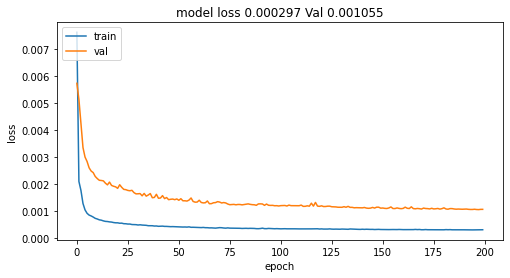

RMSE % 0 CasesNextday 11660.0 2.775 27.2302 24.9874 5.9164
RMSE % 1 DeathsNextday 11660.0 3.0649 40.0507 48.3444 13.2418
RMSE % 2 Casesday2 11220.0 2.8211 27.1557 24.8287 6.1597
RMSE % 3 Deathsday2 11220.0 3.103 39.7761 52.6015 16.64
RMSE % 4 Casesday3 11000.0 2.8427 27.0937 24.6903 5.6836
RMSE % 5 Deathsday3 11000.0 3.1161 39.5508 48.6563 12.4822
RMSE % 6 Casesday4 10780.0 2.8708 27.0868 24.8039 5.532
RMSE % 7 Deathsday4 10780.0 3.1606 39.7119 48.1993 12.8719
RMSE % 8 Casesday5 10560.0 2.9046 27.125 25.1315 6.5207
RMSE % 9 Deathsday5 10560.0 3.181 39.5587 47.9454 10.8307
RMSE % 10 Casesday6 10340.0 2.9499 27.2592 25.9392 8.4192
RMSE % 11 Deathsday6 10340.0 3.2072 39.4661 47.3169 10.7375
RMSE % 12 Casesday7 10120.0 2.9474 26.945 24.9913 6.0464
RMSE % 13 Deathsday7 10120.0 3.2443 39.4966 47.7883 11.8382
RMSE % 14 Casesday8 9900.0 2.9888 27.0241 24.8475 5.4751
RMSE % 15 Deathsday8 9900.0 3.2779 39.469 47.4861 11.1851
RMSE % 16 Casesday9 9680.0 3.0245 27.0423 24.708 5.1971
RMSE % 17 Death

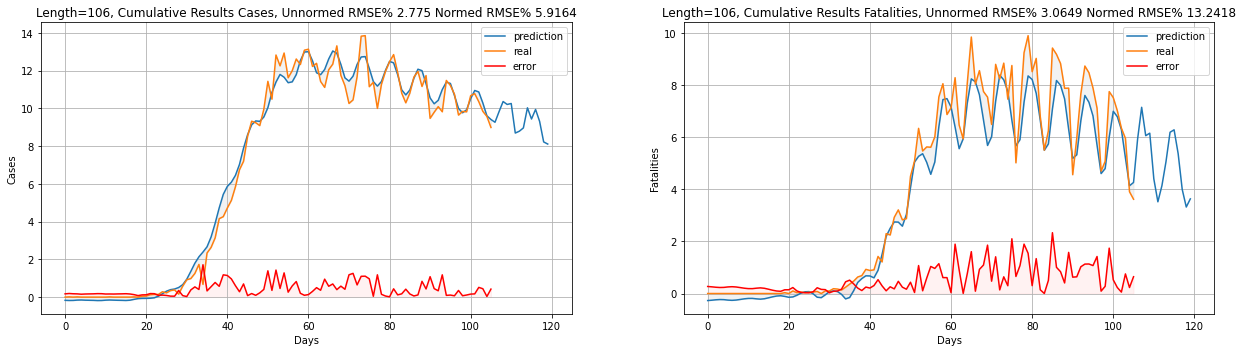

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
def StandaloneLSTM():
# run pure LSTM with no attention (transformer) with simple Keras sequential model

  X_predict, y_predict = setLSTMinput()
  X_train, y_train = shuffleDLinput(X_predict, y_predict)

  # n_timesteps=n_steps_in=Tseq, 
  # n_features= NpropperseqTOT,  
  # n_outputs = NpredperseqTOT       
  InitializeLSTM('Keras Sequential Version ',processindex,y_predict)

  # define model
  StandaloneLSTMmodel = Sequential()
  
  if(LSTMInitialMLP > 0):
      StandaloneLSTMmodel.add(Dense(LSTMInitialMLP, activation=LSTMactivationvalue, input_shape=(Tseq,NpropperseqTOT)))
      nextround = LSTMInitialMLP
  else:
      nextround = NpropperseqTOT

  StandaloneLSTMmodel.add(LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout1, dropout = LSTMdropout1,
                  activation= LSTMactivationvalue , return_sequences=True, recurrent_activation= LSTMrecurrent_activation,
                  input_shape=(Tseq, nextround)))

  if(LSTMThirdLayer):
      StandaloneLSTMmodel.add(LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout2, dropout = LSTMdropout2,
                  activation= LSTMactivationvalue , return_sequences=True, recurrent_activation= LSTMrecurrent_activation,
                  input_shape=(Tseq, number_LSTMnodes)))
      StandaloneLSTMmodel.add(LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout2, dropout = LSTMdropout2,
                      activation= LSTMactivationvalue , recurrent_activation=LSTMrecurrent_activation,
                      input_shape=(Tseq, number_LSTMnodes)))
  else:
      StandaloneLSTMmodel.add(LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout2, dropout = LSTMdropout2,
              activation= LSTMactivationvalue, recurrent_activation=LSTMrecurrent_activation,
              input_shape=(Tseq, number_LSTMnodes)))
      
  if(LSTMFinalMLP > 0):
      StandaloneLSTMmodel.add(Dense(LSTMFinalMLP, activation=LSTMactivationvalue))
  StandaloneLSTMmodel.add(Dense(NpredperseqTOT))
  
  if CustomLoss == 0:
      StandaloneLSTMmodel.compile(loss='mse', optimizer= LSTMoptimizer)
  if CustomLoss == 1:
      StandaloneLSTMmodel.compile(loss= custom_lossGCF1, optimizer= LSTMoptimizer)
  if CustomLoss == 4:    
      StandaloneLSTMmodel.compile(loss= custom_lossGCF4, optimizer= LSTMoptimizer)

  modelsummarystring = get_model_summary(StandaloneLSTMmodel)
  if( processindex == 0 ):
      print(modelsummarystring)

  the_callbacks = [TqdmCallback(),]
  if UseClassweights:   
      cw = {}
      for i in range(0,NpredperseqTOT):
        cw[i] = Predictionwgt[i]     
      modelresult = StandaloneLSTMmodel.fit(X_train, y_train,
            epochs=LSTMepochs,
            batch_size=LSTMbatch_size,
            class_weight = cw,
            verbose=LSTMverbose,
            validation_split=LSTMvalidationfrac,
            callbacks=the_callbacks
            )
  else:
      modelresult = StandaloneLSTMmodel.fit(X_train, y_train,
            epochs=LSTMepochs,
            batch_size=LSTMbatch_size,
            verbose=LSTMverbose,
            validation_split=LSTMvalidationfrac,
            callbacks=the_callbacks
            )  
  finalizeDL(StandaloneLSTMmodel, modelresult, LSTMvalidationfrac,RawInputSequencesTOT, RawInputPredictionsTOT)
  return

# RUN PURE LSTM
processindex = 0
standaloneLSTMrun = False
ClassLSTMrun = True
if standaloneLSTMrun:
  StandaloneLSTM()
if ClassLSTMrun:
  RunLSTMClassVersion()
if standaloneLSTMrun or ClassLSTMrun:
  sys.exit(0)

In [ ]:
print('Are futures predicted ' + str(UseFutures) + ' Custom Loss Pointer ' + str(CustomLoss) + ' Class weights used ' + str(UseClassweights))
print('Predictions per sequence ' + str(NpredperseqTOT))
print('Number of LSTMworkers ' + str(number_of_LSTMworkers))
print('Number of epochs for each LSTMworker ' + str(LSTMepochs))
print('Batch size for LSTM ' + str(LSTMbatch_size))
print('LSTM Activation Method ' + str(LSTMactivationvalue))
print('LSTM recurrent Activation method ' + str(LSTMrecurrent_activation))
print('LSTM Optimizer ' + str(LSTMoptimizer))
print('LSTM Dropout Layer 1 ' +str(LSTMdropout1) + 'LSTM Recurrent Dropout Layer 1 ' +str(LSTMrecurrent_dropout1) + 'LSTM Dropout Layer >= 2 ' +str(LSTMdropout2) + 'LSTM Recurrent Dropout Layer >=2 ' +str(LSTMrecurrent_dropout2))
print('Number of hidden LSTM nodes ' + str(number_LSTMnodes) + ' Is there a third LSTM layer? ' + str(LSTMThirdLayer))
print('LSTM Initial Embedding layer ' + str(LSTMInitialMLP) + ' Final LSTM Layer ' + str(LSTMFinalMLP))
print('LSTM Verbose Option ' + str(LSTMverbose))
print('LSTM Validation Fraction ' +str(LSTMvalidationfrac) + ' Method to chose best solution '+ str(bestmethod))

Are futures predicted True Custom Loss Pointer 1 Class weights used True
Predictions per sequence 30
Number of LSTMworkers 1
Number of epochs for each LSTMworker 200
Batch size for LSTM 110
LSTM Activation Method selu
LSTM recurrent Activation method sigmoid
LSTM Optimizer adam
LSTM Dropout Layer 1 0.2LSTM Recurrent Dropout Layer 1 0.2LSTM Dropout Layer >= 2 0.2LSTM Recurrent Dropout Layer >=2 0.2
Number of hidden LSTM nodes 16 Is there a third LSTM layer? False
LSTM Initial Embedding layer 32 Final LSTM Layer 64
LSTM Verbose Option 0
LSTM Validation Fraction 0.2 Method to chose best solution 2


# Setting up the Transformer for COVID

Other data from LSTM defining COVID problem



The original had a BUFFERSIZE removed

Compared to original with a single sequence label and dimension, inp_seq_len or d_sample, we have two sequence labels

iseq = range(0..Tseq) time

iloc = range(0..Nloc) sample location

## Important Parameters defining Transformer project

In [ ]:
Transformerbatch_size = 2
Transformervalidationfrac = 0.0
Transformerepochs = 100
Transformeroptimizer ='adam'
Transformerverbose = 0
TransformerFullAttention = False
d_model =128
d_Attention = 2 * d_model
if TransformerFullAttention:
  d_Attention = d_model
num_heads = 4
num_Encoderlayers = 4
EncoderDropout= 0.1
EncoderActivation = 'selu'
d_EncoderLayer = d_Attention
d_merge = d_model
d_ffn = 4*d_model
MaskingOption = 0
PeriodicInputTemporalEncoding = 7 # natural for COVID
LinearInputTemporalEncoding = -1 # natural for COVID
TransformerInputTemporalEncoding = 10000
UseTransformerInputTemporalEncoding = False

In [ ]:
# Output parameters used in this Science Transformer

print("Batch size of stochastic gradient descent Transformerbatch_size ", str(Transformerbatch_size))
print("Fraction used for a validation dataset ", str(Transformervalidationfrac))
print("Dimension of value embedding for every input [Model1] d_model ", str(d_model))
print("Dimension of value embedding for input to Decoder (LSTM) ", str(d_merge))
print("Number of Attention Heads which must exactly divide d_model, num_heads ", str(num_heads))
print("Number of layers in Encoder stage num_Encoderlayers ", str(num_Encoderlayers))
print("Dropout in Encoder stage, EncoderDropout ", str(EncoderDropout))
print("Size of Encoder stage, d_EncoderLayer ", str(d_EncoderLayer))
print("Activation in Encoder Stage EncoderActivation ",str(EncoderActivation))
print("Size of feedforward network in each encoder layer. It appears to be 4 * d_model, d_ffn ", str(d_ffn))
print("Defines masking used; = 0 none; =1 mask the future MaskingOption ", str(MaskingOption))
print("Defines use of periodic time encoding; =0 none; > 0 use time encoding with this period [ 7 weekly, 365 annual). Note this added as a property of each input (actually two as cos-theta and sin-theta), PeriodicInputTemporalEncoding ", str(PeriodicInputTemporalEncoding))
print("Defines use of linear time encoding; =0 none; =-1 make linear over full time range. Note this added as a single property of each input, LinearInputTemporalEncoding ", str(LinearInputTemporalEncoding))
print("Defines structure of Transformer-style time encoding; =0 none; > 0 use time encoding with this base (10000 in transformer example) TransformerInputTemporalEncoding ", str(TransformerInputTemporalEncoding))
print("Defines use of Transformer-style time encoding; UseTransformerInputTemporalEncoding ", str(UseTransformerInputTemporalEncoding))


***Num_Seq*** Number of Sequences

***Nloc*** Number of locations

***Tseq*** Length of each sequence

***Npropperseq*** Number of internal properties per sequence including static or dynamic

***NpredperseqTOT*** Total number of predictions per sequence

***d_model*** Dimension of value embedding for every input [Model1] 

***num_heads*** Number of Attention Heads which must exactly divide ***d_model***

***num_Encoderlayers*** Number of layers in Encoder stage

***EncoderDropout*** Dropout in Encoder stage, 

***d_ffn*** Size of feedforward network in each encoder layer. It appears to bet to be 4 * ***d_model*** 

***MaskingOption*** defines masking used; = 0 none; =1 mask the future

***PeriodicInputTemporalEncoding*** defines use of periodic time encoding; =0 none; > 0 use time encoding with this period [ 7 weekly, 365 annual). Note this added as a property of each input (actually two as cos-theta and sin-theta)

***LinearInputTemporalEncoding*** defines use of linear time encoding; =0 none; =-1 make linear over full time range. Note this added as a single property of each input

***TransformerInputTemporalEncoding*** defines use of Transformer-style time encoding; =0 none; > 0 use time encoding with this base (10000 in transformer example)

***Transformerbatch_size*** is batch size of stochastic gradient descent

***Tseq*** is size of sequence window

***Transformervalidationfrac*** is fraction used for a validation dataset

***d_sample*** The number of units presented to the Transformer which could be dynamic. Each of these inputs is used to calculate attention and is Tseq times number of locations simultaneously presented

***max_d_sample*** The maximum number of units presented to the Transformer which is fixed. It is Tseq times maximum number of locations simultaneously presented

***TransformerFullAttention*** if True calculate classic attention over all d_sample members; if False calculate separate attentions in location and time

Describe the science data sets here

Initial data is [Num_Seq][Nloc][Tseq] with values [Nforcing + ExPosEnc-Selin + Nprop-Sel]

Predictions are [Num_Seq] [Nloc] [Predvals=Npred+ExPosEnc-Selout] [Predtimes = Forecast-time range]

A subset is included in each transformer call. There are 3 options
*   Simplest: (as in LSTM) samples are labelled by [Num_Seq] [Nloc] and have input length [Tseq] with multiple features [Nforcing + ExPosEnc-Selin + Nprop-Sel] mapped into a model for each input of length [Model1]. Predictions for each input are [Predvals] [Predtimes]
*   Straightforward improvement:  Divide Nloc into sublocation groups giving Nloc/Nsub groups with Nloc-Nsub locations in each group. There are many choices of groups including fixed disjoint subgroups, overlapping groups (so that each epoch surveys each location twice and this should help spread attention). Then each sample is labelled by [Num_Seq] [Nloc/Nsub] and have input length [Nloc-Nsub][Tseq] with multiple features [Nforcing + ExPosEnc-Selin + Nprop-Sel] mapped into a model for each input of length [Model1]. Predictions for each input are [Predvals] [Predtimes]
*   (Too) Clever: Use different selections for Encoder and Decoder steps. For example feed all Nloc locations into transformer but oinly use through multi-headed attention step. One only takes a subset of these through encoder and predictions. This ensures that attention covers all locations
*   Extend "Too clever"  or "Straightforward" method for multiple initial time values in each transformer input i.e. divide [Num_Seq] into [Num_Seq/Ntsub] groups and input [Num_Seq-Ntsub] time sequences into a single transformer. This spreads attention over time. 

We can represent all the above cases by lasbelling each data sample by
{[Num_Seq][Nloc]} [Tseq] where always members of sequences are complete and selection of sequences and location for a single data sample varies in options above. Each member of a data sample has [Nforcing + ExPosEnc-Selin + Nprop-Sel] internal degrees of freedom. These degrees of freedom will be mapped (embedded) in a model variable of length ***d_model***

Size of input is ***d_sample*** = Tseq * size {[Num_Seq][Nloc]} in a single data sample. This is important throughout network whereas [Nforcing + ExPosEnc-Selin + Nprop-Sel] is immediately embedded and becomes of length ***d_model***







In [ ]:
# Set up data
# Initial data is [For Batching][Nloc_sample] [Tseq] [NpropperseqTOT] starting with RawInputSequencesTOT
# Predictions are [For Batching][Nloc_sample] [NpredperseqTOT] starting with RawInputPredictionsTOT
#  For case Nloc_sample = Nloc, the Batching is identical to Time sequence label
# dsample Tseq * Nloc

Nloc_sample = Nloc
Num_Seq_TimeandLoc = Num_seq
if Nloc%Nloc_sample != 0:
  print("Inconsistent location numbers " + str(Nloc) + ' ' + str(Nloc_sample))
  sys.exit()
d_sample = Tseq * Nloc
max_d_sample = d_sample
Transformermaximum_position_encoding = max_d_sample
X_Transformerdetailed = numpy.copy(RawInputSequencesTOT)
y_Transformerdetailed = numpy.copy(RawInputPredictionsTOT)
X_Transformerflat = numpy.reshape(X_Transformerdetailed, (Num_Seq_TimeandLoc, d_sample, NpropperseqTOT))
y_Transformerflat = numpy.reshape(y_Transformerdetailed, (Num_Seq_TimeandLoc, Nloc, NpredperseqTOT))

# We need to shuffle for training data but unshuffled (unflattened) data will be used in evaluation
X_predict, y_predict = shuffleDLinput(X_Transformerflat, y_Transformerflat)

print("The maximum number of units presented to the Transformer which is fixed.It is Tseq times maximum number of locations simultaneously presented ", str(max_d_sample))
print("The actual number of units presented to the Transformer for this batch.It is Tseq times  number of locations simultaneously presented in  this batch ", str(max_d_sample))
print(" Number of locations in each sample presented to the Transformer ", str(Nloc_sample))
print("Number of locations times sequence window length in each sample presented to the Transformer ", str(Num_Seq_TimeandLoc))

## Positional encoding Text and Code

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

I am not certain if Science wants this type of encoding and/or the positional coding controlled by ***PeriodicInputTemporalEncoding*** and
***LinearInputTemporalEncoding***.

***TransformerInputTemporalEncoding*** controls this. TransformerInputTemporalEncoding = 10000  will give example given here

The base 10000 needs study but otherwise we use this function below later-on

The Blogs/papers on BERT have discussion of more sophisticated multi-sentence encoding in BERT

Also another Blog questions why this encoding added rather that being concatenated

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(TransformerInputTemporalEncoding, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
pos_encoding = positional_encoding(max_d_sample, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()
if not UseTransformerInputTemporalEncoding:
  print(startbold + 'Classic Transformer Encoding not used' +resetfonts)

## Masking Text and Code

Masking could be used in time. Basic logic similar between science and NLP. There will be no masking in location.

Use flag ***MaskingOption*** to define masking used; = 0 none; =1 mask the future

Note use of NaN to indicate undefined predicted values. That must be handled in loss function.

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])

if MaskingOption == 0:
  print(startbold + 'Classic Transformer Masking not used' +resetfonts)


## Scaled dot product attention for Science

This seems unchanged for science case unless ***d_sample*** is too large. One wastes time then if softmaxes too small. It could be useful just to select the largest (e.g. take top 10 or remove all probabilities < 0.001) softmax values and just process with these

Below all vectors Q K V have size ***d_model/num_heads***. They are defined for each head and for each sample member of the ***d_sample*** members

This could use the  mask described earlier but that is not used in initial version

We have a hierarchial sequence label which limits number of softmaxes calculated although number of Q K V vectors are not reduced

## Scaled dot product attention: Q K V Softmax

### Discussion and Science version

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  # Needs externally defined  Num_heads, d_sample, Nloc_sample, Tseq, d_model
  # Calculates depth
  """
  Calculate the attention weights after Q K V found
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

In the science Transformer, Q K V are all Batch, Num_heads, d_sample, depth
where Q K V all have same number of samples d_sample
depth is always d_model/num heads

d_sample is really [Nloc_sample][Tseq] and calculates separate Location and Time Attention

Original returned attention weights but ignored. We do NOT return but rather return two attention vectors in Location and Time
If TransformerFullAttention specified, it returns  traditional full attention vector
  Returns:
    AttentionVector1 concatenated with AttentionVector2
  """
  # To scale matmul_qk
  depth = tf.shape(k)[-1]
  dk = tf.cast(depth, tf.float32) # dk is depth in all methods

  if TransformerFullAttention:
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # [Batch, Num_heads, d_sample, depth] [Batch, Num_heads, (d_sample, depth)T ]
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk) # [Batch, Num_heads, d_sample, dsample]

    # add the mask to the scaled tensor.
    if mask is not None:
      scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k = d_sample) so that the scores add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # scaled_attention_logits [Batch, Num_heads, d_sample, d_sample] 

    AttentionVectorfull = tf.matmul(attention_weights, v)  # [Batch, Num_heads, d_sample, d_sample] [Batch, Num_heads, d_sample, depth]
    AttentionVectortemp = tf.transpose(AttentionVectorfull, perm = [0,2,1,3]) # [Batch,  d_sample, Num_heads, depth]
    AttentionVector = tf.reshape(AttentionVector1time, [q.shape[0],d_sample, d_model]) # restore shape

else:
  # Calculate Attention in Time. This requires no reordering and so can be redone with shape
  # Note matmul works for all number of indices and multiplication is only done on last 2 indices so using qtime means we look at attention with location fixed
  # No mask used with this
  qtime = tf.reshape(q, [q.shape[0], Num_heads, Nloc_sample, Tseq, depth ])
  ktime = tf.reshape(k, [k.shape[0], Num_heads, Nloc_sample, Tseq, depth ])
  vtime = tf.reshape(v, [v.shape[0], Num_heads, Nloc_sample, Tseq, depth ])
  matmul_qk = tf.matmul(qtime, ktime, transpose_b=True)  # [Batch, Num_heads, Nloc_sample, Tseq, depth] [Batch, Num_heads, Nloc_sample, (Tseq, depth)T ]
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk) # [Batch, Num_heads, Nloc_sample, Tseq, Tseq]

  # softmax is normalized on the last axis (Tseq) so that the scores add up to 1 in time direction separately for each space.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # scaled_attention_logits [Batch, Num_heads, Nloc_sample, Tseq, Tseq] 

  AttentionVector1time = tf.matmul(attention_weights, vtime)  # [Batch, Num_heads, Nloc_sample, Tseq, Tseq] [Batch, Num_heads,  Nloc_sample, Tseq, depth] becomes [Batch, Num_heads, Nloc_sample, Tseq, depth]
  AttentionVector1temp = tf.transpose(AttentionVector1time, perm = [0,2,3,1,4]) # [Batch,  Nloc_sample, Tseq, Num_heads, depth]
  AttentionVector1 = tf.reshape(AttentionVectortemp, [q.shape[0],d_sample, d_model]) # restore shape

# Code below rewrites arrays
  qspace = tf.transpose(qtime, perm = [0,1,3,2,4]) # [Batch, Num_heads, Tseq, Nloc_sample,  depth]
  kspace = tf.transpose(ktime, perm = [0,1,3,2,4]) # [Batch, Num_heads, Tseq, Nloc_sample,  depth]
  vspace = tf.transpose(vtime, perm = [0,1,3,2,4]) # [Batch, Num_heads, Tseq, Nloc_sample,  depth]
  matmul_qk = tf.matmul(qspace, kspace, transpose_b=True)  # [Batch, Num_heads, Tseq, Nloc_sample, depth] [Batch, Num_heads, Tseq, (Nloc_sample, depth)T ]
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk) # [Batch, Num_heads, Tseq, Nloc_sample, Nloc_sample]

  # softmax is normalized on the last axis (Nloc_sample) so that the scores add up to 1 in location direction separately for each space.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # scaled_attention_logits [Batch, Num_heads, Tseq, Nloc_sample,  Nloc_sample] 

  AttentionVector2space = tf.matmul(attention_weights, vspace)  # [Batch, Num_heads, Tseq, Nloc_sample,  Nloc_sample] [Batch, Num_heads, Tseq, Nloc_sample,  depth] becomes [Batch, Num_heads, Tseq, Nloc_sample,  depth]
  AttentionVector2temp = tf.transpose(AttentionVector2space, perm = [0,3,2,1,4]) # [Batch,  Nloc_sample, Tseq, Num_heads, depth]
  AttentionVector2 = tf.reshape(AttentionVector2temp, [q.shape[0], d_sample, d_model ]) # restore shape

  AttentionVector = tf.concat([AttentionVector1,AttentionVector2], -1) # [Batch, d_sample,2*d_model =d_Attention] 

return AttentionVector # [Batch, Num_heads, d_sample,depth] or [Batch, Num_heads, d_sample,2*depth] 

### scaled_dot_product_attention Example

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [ ]:
def print_out(q, k, v):
  save = TransformerFullAttention
  TransformerFullAttention = True
  temp_out, = scaled_dot_product_attention(
      q, k, v, None)
  print ('Output is:')
  print (temp_out)
  TransformerFullAttention =  save

In [ ]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

In [ ]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

In [ ]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Pass all the queries together.

In [ ]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

## **Multi-head attention for Science**

Multi-head attention should be identical between Science ad NLP 

Note assertion that ***num_heads*** divides ***d_model***

The annotation has seq_len and similar notations which is ***d_sample***

***depth*** is calculated. It is number of words in each instance of Q, K, V for one head. Note that Q, K, V are concatenated over heads for efficient computation

We suggest possibility of doing attention not across all d_sample inputs but rather separately in time and in location. This is implemented in "Scaled Dot Product Attention"

We also allow d_Attention final size to be different from input d_model. Further we put correction of splitting into "Scaled Dot Product Attention" as it is naturally combined with other tensor reshape/transformations

### Multi-head Attention Discussion and Science version

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  # Feed in d_model, num_heads. Nothing assumed. Other sizes implied by tensors
  # seq_len = seq_len_q = seq_len_k= seq_len_v below is d_sample

  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert self.d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    if d_model != d_Attention:
      self.wq2 = tf.keras.layers.Dense(d_model)
      self.wk2 = tf.keras.layers.Dense(d_model)
      self.wv2 = tf.keras.layers.Dense(d_model)

    self.finaldense = tf.keras.layers.Dense(d_Attention)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    if tf.shape(q)[-1] == d_model:  
      q = self.wq(q)  # (batch_size, seq_len, d_model)
      k = self.wk(k)  # (batch_size, seq_len, d_model)
      v = self.wv(v)  # (batch_size, seq_len, d_model)
    else:
      q = self.wq2(q)  # (batch_size, seq_len, d_model)
      k = self.wk2(k)  # (batch_size, seq_len, d_model)
      v = self.wv2(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size,  seq_len_q, d_Attention)
    concat_attention = scaled_dot_product_attention(q, k, v, mask)

    output = self.finaldense(concat_attention)  # (batch_size, seq_len_q, d_Attention)
    return output

### MultiHeadAttention Example

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out = temp_mha(y, k=y, q=y, mask=None)
out.shape

## **Point wise feed forward network** (Original and Science)

This is used in encoder (each) layer and the decoder.  The activation layer could be 'relu' or 'selu'.

dff in code is our parameter ***d_ffn*** (size of first layer in feef forward network) and defaults to 4 * ***d_model***

Point wise feed forward network consists of two fully-connected layers with a relu or selu activation in between.

In [ ]:
def point_wise_feed_forward_network(d_EncoderLayer, d_ffn):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(d_ffn, activation=EncoderActivation),  # (batch_size, seq_len, d_ffn)
      tf.keras.layers.Dense(d_EncoderLayer)  # (batch_size, seq_len, d_EncoderLayer)
  ])

In [ ]:
# Example of Point wise feed forward network
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

## **Encoder and decoder**

Note the process starts with an ***Encoder*** and finishes with a ***Decoder***. These share components like multi-headed attention. We expect to look at different Decoders for science as we want floating point numbers and not as in NLP, members of a vocabulary We expect that decoder could be similar for science and NLP as it is looking for structure and that is a set of relationships which could be similar between science and NLP. .

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer (Original and Science)

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_EncoderLayer` (last) axis. There are N = ***num_Encoderlayers*** encoder layers in the transformer.


I am not clear why x and sublayer(x) (input and output, out1 + ffn_output) are added. I would have concatenated. I had a similar comment on positional encoding which is added to rather than being appended to input. For science the numbers matter -- its not just patterns!

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention()
    self.ffn = point_wise_feed_forward_network(d_EncoderLayer, d_ffn)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(EncoderDropout)
    self.dropout2 = tf.keras.layers.Dropout(EncoderDropout)
    
  def call(self, x, training, mask):

# mha adjusts to shape[-1] of x being d_model or d_EncoderLayer
    attn_output = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    if d_EncoderLayer == d_model:
      addtogether = x + attn_output
    else:
      doublex = tf.concat([x,x], -1)
      addtogether = doublex + attn_output 
    out1 = self.layernorm1(addtogether)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_EncoderLayer)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_EncoderLayer)
    
    return out2

In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

### Decoder layer (Original)
**Currently we do not expect to use this in science but later we may return**

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    print("GCF6 ", np.shape(x), np.shape(out1), np.shape(out2), np.shape(out3))
    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

### Encoder (Original)

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__():
    super(Encoder, self).__init__()
    
   # self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.dense_1 = tf.keras.layers.Dense(d_model, activation=Encoderactivation)
    if UseTransformerInputTemporalEncoding:
      self.pos_encoding = positional_encoding(Transformermaximum_position_encoding, d_model)
    
    self.enc_layers = [EncoderLayer() for _ in range(num_Encoderlayers)]
    self.dropout = tf.keras.layers.Dropout(EncoderDropout)
        
  def call(self, x, training, mask):
  
  # adding embedding and position encoding.
  # x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
  # x *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    x = self.dense_1(x)

    if UseTransformerInputTemporalEncoding:
      seq_len = tf.shape(x)[1]
      x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(num_Encoderlayers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, d_sample, d_EncoderLayer)



In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)


### Encoder for Science

The encoder for Science is very close to the NLP version
Its output is TWO arrays
* The result of self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model) before NLP position encoding applied
* The same output of Encoder used in NLP

Both are (***Transformerbatch_size***, ***d_sample***, ***d_model***)

Note this is analogous to RESNET that adds input to output after several convolutional layers. We maybe incorrectly are concatenating not adding

This interpreted as original embedded data which would have been fed into an LSTM in that model plus a second vector summarizing result of attention analysis -- a form of generalized history

We will need to convert the ***d_sample*** index to two indices ***Tseq*** * size {[Num_Seq][Nloc]}

We can run members of size {[Num_Seq][Nloc]} together in LSTM although this is not how it is done normally in pure LSTM. Alternatively we can run each sample member separately

Note each member of sample has a separate encoder output

### Decoder (Original)

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    print("GCF4 ", np.shape(x))
    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    print("GCF5 ", np.shape(x))
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None )
output.shape, attn['decoder_layer2_block2'].shape

### Decoder for Science
This is not like the NLP Decoder. Rather it will use the same two layer LSTM we have already tested extensively in COVID.

There are two important changes
1. In COVID the equivalent of ***d_sample*** held just ***Tseq*** entries -- a single window for one location. Now we feed in a window of length Tseq as in COVID but the input data is muliple cases of size {[Num_Seq][Nloc]}. As we expect to start with one  sequence per network input this is just the number of locations.
2. For each presented case, we intend to use not ust the output of encoder but rather the concatenation of two vectors of length ***d_model***

* The result of self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model) before NLP position encoding applied
* The same output of Encoder used in NLP containing concatenated attention head results

There are two possibilities to consider
1. That described above with a single input to decoder of length 2 * ***d_model*** * ***d_sample/Tseq***
2. ***d_sample/Tseq*** separate runs (in parallel or one after the other) each containing one case. This is safest" approach as closely mimics that used in COVID

Note this LSTM subsystem ends with a small FCN and so we don't need an additional linear layer

In [ ]:
def EncodertoLSTMmerge(tf.keras.layers.Layer):
  def __init__():
    super(EncodertoLSTMmerge, self).__init__()
    self.dense_merged = tf.keras.layers.Dense(d_merge, activation=Encoderactivation)

def call(self, Originalinput, EncoderOutput):

  Originalinput = tf.reshape(Originalinput, [Originalinput.shape[0], Nloc_sample, Tseq, NpropperseqTOT])
  EncoderOutput = tf.reshape(EncoderOutput, [EncoderOutput.shape[0], Nloc_sample, Tseq, d_EncoderLayer])
  Merged = tf.concat([Originalinput,EncoderOutput], -1)
  Merged = self.dense_merged(Merged)

  return Merged

# Transformer for Science

In [ ]:
class MyScienceTransformermodel(tf.keras.Model):
  def __init__(self, **kwargs):
    super(MyScienceTransformermodel, self).__init__(**kwargs)


    self.Scienceencoder = Encoder()
    self.Sciencemerge = EncodertoLSTMmerge()
    self.fullLSTM = MyLSTMlayer() # Identical to that used in standalone LSTM

  def call(self, inputs):  
    # Here input is  flattened over Nloc_sample and Tseq although this is exposed and then flattened in scaled_dot_product_attention
    Encoderoutput = self.Scienceencoder(inputs, training =settraining, mask = None)

    # Here we expose separate dimensions Nloc_sample and Tseq
    compositeinputs = self.Sciencemerge(inputs,Encoderoutput)
    outputs = self.fullLSTM(compositeinputs)
    return outputs

def RunScienceTransformer():
# Run the Science Transformer model defined by Model and Encoder/LSTM classes
# Assumes X_predict, y_predict

  X_train, y_train = shuffleDLinput(X_predict, y_predict)
  settraining = True
  LSTMInitialMLP = 0
  myScienceTransformermodel = MyScienceTransformermodel(name ='myScienceTransformermodel')
  if CustomLoss == 0:
      myScienceTransformermodel.compile(loss='mse', optimizer= Transformeroptimizer)
  if CustomLoss == 1:
      myScienceTransformermodel.compile(loss= custom_lossGCF1, optimizer= Transformeroptimizer)
  if CustomLoss == 4:    
      myScienceTransformermodel.compile(loss= custom_lossGCF4, optimizer= Transformeroptimizer)

  the_callbacks = [TqdmCallback(),]

  if UseClassweights:   
      cw = {}
      for i in range(0,NpredperseqTOT):
        cw[i] = Predictionwgt[i]     
      modelresult = myScienceTransformermodel.fit(X_train, y_train,
            epochs=Transformerepochs,
            batch_size=Transformerbatch_size,
            class_weight = cw,
            verbose=Transformerverbose,
            validation_split=Transformervalidationfrac,
            callbacks=the_callbacks
            )
  else:
      modelresult = myScienceTransformermodel.fit(X_train, y_train,
            epochs=Transformerepochs,
            batch_size=Transformerbatch_size,
            verbose=Transformerverbose,
            validation_split=Transformervalidationfrac,
            callbacks=the_callbacks
            ) 
  myScienceTransformermodel.summary()
  settraining = False
  finalizeDL(myScienceTransformermodel,modelresult)
  return

# Finally we can run the Science Transformer
LaunchScienceTransformer = True
if LaunchScienceTransformer:
  RunScienceTransformer()

# Create the Original Transformer 

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

(Original Only. No further material used for Science Transformer)

In [ ]:
sys.exit('Rest is Old')

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)
    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    print("GCF3 ENC OUT", np.shape(enc_output), " MASKS ", np.shape(look_ahead_mask),  np.shape(dec_padding_mask), " DEC OUT ", np.shape(dec_output))
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)
sample_transformer.summary()

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## Training and checkpointing

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](./text_generation.ipynb)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [ ]:
EPOCHS = 20

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

Portuguese is used as the input language and English is the target language.

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the Portuguese tokenizer (`tokenizer_pt`). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == tokenizer_en.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [ ]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_pt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [ ]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)